# Задание 1. Статистика

Руководство компании обратило внимание на то, что сотрудники старше 35 лет болеют чаще, чем более молодые сотрудники. Кроме этого, среди мужчин количество пропусков рабочих дней в связи с больничным выше, чем среди женщин. В связи с этой ситуацией, руководство организации планирует ввести дополнительные медицинские осмотры среди групп риска. 
Необходимо проверить следующие гипотезы:

1)	Мужчины пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще женщин.

2)	Работники старше 35 лет (age) пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще своих более молодых коллег.


## 1. Загрузка и подготовка данных

In [1]:
import pandas as pd
from scipy import stats as st
import seaborn as sns
from numpy.random import RandomState
import matplotlib.pyplot as plt

state = RandomState(42)

In [2]:
work_days = 2
age = 35

У этих данных есть особенность, они имеют encoding = ANSI, поэтому `read_csv` передадим параметр `encoding` равный `mbcs`:

In [3]:
data = pd.read_csv('Статистика.csv', encoding='mbcs')

In [4]:
data

,Количество больничных дней,Возраст,Пол
0,5,39,Ж
1,4,54,М
2,4,26,М
3,5,42,М
4,4,29,М
...,...,...,...
232,5,30,М
233,4,36,Ж
234,2,60,Ж
235,2,44,Ж


Поскольку требуется определить пропускает ли более 2 рабочих дней работник, то введем новую колонку, которая принимает `True`, если количество больничных дней более 2, иначе `False`. Переведем колонку сразу в целочисленный тип:

In [5]:
data['is_greater_than'] = data['Количество больничных дней'] > work_days
data = data.astype({'is_greater_than': 'int32'})

## 2. Проверка гипотез

### 2.1. Bootstrap 

Колонка `is_greater_than` имеет распределение Бернулли, поэтому применим метод `Bootstrap` для получения выборки нормального распределения.

In [6]:
m = []
w = []
workers_older = []
workers_younger = []


for i in range(5000):
    m.append(data[data['Пол'] =='М'].sample(frac=1, replace=True, random_state=state)['is_greater_than'].mean())
    w.append(data[data['Пол'] =='Ж'].sample(frac=1, replace=True, random_state=state)['is_greater_than'].mean())
    workers_older.append(data[data['Возраст'] >= age].sample(frac=1, replace=True, random_state=state)['is_greater_than'].mean())
    workers_younger.append(data[data['Возраст'] < age].sample(frac=1, replace=True, random_state=state)['is_greater_than'].mean())

m = pd.Series(m)
w = pd.Series(w)
workers_older = pd.Series(workers_older)
workers_younger = pd.Series(workers_younger)

### 2.2. Графики получившихся распределений

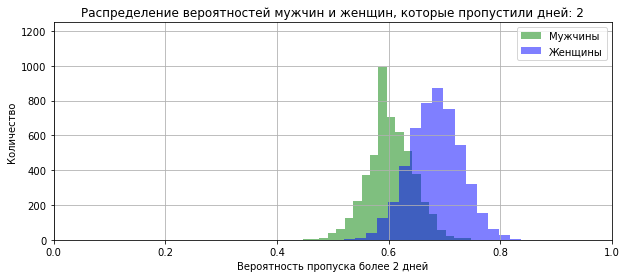

In [7]:
fig = plt.figure(figsize=(10, 4))
ax = plt.axes(xlim=(0, 1), ylim=(0, 1250))
plt.title('Распределение вероятностей мужчин и женщин, которые пропустили дней: ' + str(work_days))
plt.xlabel("Вероятность пропуска более " + str(work_days) + " дней")
plt.ylabel("Количество")
m.hist(color='green', alpha = 0.5, bins=20)
w.hist(color='blue', alpha = 0.5, bins=20)
ax.legend(['Мужчины', 'Женщины'])
plt.show()

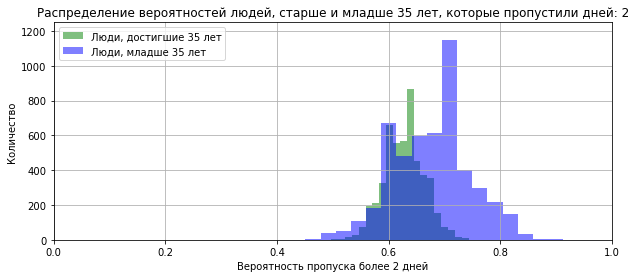

In [8]:
fig = plt.figure(figsize=(10, 4))
ax = plt.axes(xlim=(0, 1), ylim=(0, 1250))
plt.title('Распределение вероятностей людей, старше и младше ' + str(age) + ' лет, которые пропустили дней: ' + str(work_days))
plt.xlabel("Вероятность пропуска более " + str(work_days) + " дней")
plt.ylabel("Количество")
workers_older.hist(color='green', alpha = 0.5, bins=20)
workers_younger.hist(color='blue', alpha = 0.5, bins=20)
ax.legend(['Люди, достигшие ' + str(age) + ' лет', 'Люди, младше ' + str(age) + ' лет'])
plt.show()

### 2.3. Проверка гипотез

Проверять гипотезы будем по t-критерию Уэлча, поскольку нет оснований полагать, что дисперсии выборок равны. Такой метод реализован в `scipy.stats` функцией `ttest_ind(a, b, equal_var=False)`. За нулевую гипотезу возьмем равенство средних, за альтернативную среднее первой выборки больше чем у второй. Поэтому в функции укажем `alternative='greater'`.

**1) Проверка гипотезы: Мужчины пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще женщин:**

```
H_0: Количество больничных дней мужчин более 2 дней (work_days) = количество больничных дней женщин более 2 дней (work_days)
H_a: Количество больничных дней мужчин более 2 дней (work_days) > количество больничных дней женщин более 2 дней (work_days)
alpha = 0.05
```

In [9]:
results = st.ttest_ind(m, w, equal_var=False, alternative='greater') # вызов метода для проверки гипотезы

alpha = .05 # alpha = значение уровня значимости

print('p-value =', results.pvalue) # вывод значения p-value на экран
print('t-статистика Уэлча:', results.statistic)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') # условный оператор с выводом строки с ответом

p-value = 1.0
t-статистика Уэлча: -89.24263003801234
Не получилось отвергнуть нулевую гипотезу


**2)	Работники старше 35 лет (age) пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще своих более молодых коллег.**

```
H_0: Количество больничных дней более 2 дней (work_days) работников старше 35 лет (age) = количество больничных дней более 2 дней (work_days) работников моложе 35 лет (age)
H_a: Количество больничных дней более 2 дней (work_days) работников старше 35 лет (age) > количество больничных дней более 2 дней (work_days) работников моложе 35 лет (age)
alpha = 0.05
```

In [10]:
results = st.ttest_ind(workers_older, workers_younger, equal_var=False, alternative='greater') # вызов метода для проверки гипотезы

alpha = .05 # alpha = значение уровня значимости

print('p-value =', results.pvalue) # вывод значения p-value на экран
print('t-статистика Уэлча:', results.statistic)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') # условный оператор с выводом строки с ответом

p-value = 1.0
t-статистика Уэлча: -43.149576024421414
Не получилось отвергнуть нулевую гипотезу
